In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.stem.snowball import EnglishStemmer
from nltk import RegexpTokenizer

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
import matplotlib.pyplot as plt
#from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline

In [61]:
# Из наброска кода
messages = pd.read_csv('SMSSpamCollection', sep='\t', names=["label", "message"])
messages

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


Задание 1(+6). Проверить, сбалансирован ли датасет (может быть, наблюдений одного класса слишком много?). Какие результаты покажет dummy classifier, который будет всем новым наблюдениям присваивать класс ham? Насколько плохо такое решение для задачи определения спама?
Грубое решение - включить в training set только необходимое число наблюдений (примерно поровну spam и ham).

Нормализовать тексты и обучить байесовскую модель (bag of words). Проверить, как влияют на результат:

1) разная токенизация: в одном случае знаки препинания удалять, в другом — считать их токенами; 

2) лемматизация (отсутствие лемматизации, стемминг, лемматизация; инструменты можно использовать любые, например, nltk.stem); 

3) удаление стоп-слов, а также пороги минимальной и максимальной document frequency;

4) векторизация документов (CountVectorizer vs. TfIdfVectorizer);

5) что-нибудь ещё?

При оценке классификатора обратите внимание на TP и FP.

In [62]:
# Из наброска кода, тааакс посмотрим на статистичку
messages.groupby('label').describe()

message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

Отсюда мы видим, что выборка несбалансирована - спама гораздо меньше (747), чем хама (4825). В такои случае мы должны уравнять спам и хам по количеству (хоть это и грубое решение, я что-то не могу придумать, как это можно было бы сделать по-другому, иначе результат будет нерелевантен).

In [63]:
spam = messages[messages['label'] == 'spam']
ham = messages[messages['label'] == 'ham'][:len(spam)]
messages = pd.concat([spam, ham])
messages['length'] = messages['message'].map(lambda text: len(text))

In [64]:
# Функция для токенизации, удаляющей знаки препинания. Тоже из наброска код
def tokenize(text):
    text = text.lower()
    return word_tokenize(text)
#messages.message.head().apply(tokenize_punc)
#messages.message = messages.message.apply(tokenize_punc)
#print(messages.head())

Сразу заметно, что в спаме используется очень много !!

In [65]:
# В последнующей работе выдавалась ошибка из-за небинароности спам и хам, поэтому перевожу спам - 1, хам - 0
messages['label'] = messages['label'].map({'ham': 0, 'spam': 1}).astype(int)

In [66]:
# Функция для токенизации, сохраняющей знаки препинания.
def tokenize_punc(text):
    text = text.lower()
    return wordpunct_tokenize(text)
#messages.message.head().apply(tokenize_punc)
#messages.message = messages.message.apply(tokenize_punc)
#print(messages.head())

In [67]:
# Стемматизация
def tokenize_stem(text):
    stems = []
    for i in RegexpTokenizer(r'\w+').tokenize(text):
        stems.append(EnglishStemmer(ignore_stopwords=True).stem(i))            
    return stems

In [68]:
# Стоп-слова подкатили
stopwords = stopwords.words('english')

In [69]:
# Из интернета, это же я видела у некоторых своих коллег
# Для рисования кривой
def draw_roc_curve(label_pred):
    print('Draw roc curve')
    false_positive_rate, true_positive_rate, thresholds = roc_curve(label_test, label_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def train_model_show_results(steps):
    pipeline = Pipeline(steps=steps)

    cv_results = cross_val_score(pipeline,
                                 text_train,
                                 label_train,
                                 cv=10,
                                 scoring='accuracy',
                                 )
    print(cv_results.mean(), cv_results.std())

    pipeline.fit(text_train, label_train)
    label_pred = pipeline.predict(text_test)
    print(label_pred)

    print(classification_report(label_test, label_pred))

    return pipeline, label_pred

In [70]:
# Векторизуем по CountVectorizer (часть кода из наброска) и смотрим на DummyClassifier
bow = CountVectorizer()
bow.fit_transform(messages['message'])

bowed_messages = bow.transform(messages['message'])
dummy_model = DummyClassifier(random_state=0, strategy='most_frequent')
dummy_model.fit(bowed_messages, messages['label'])
print(classification_report(messages['label'], dummy_model.predict(bowed_messages)))


             precision    recall  f1-score   support

          0       0.50      1.00      0.67       747
          1       0.00      0.00      0.00       747

avg / total       0.25      0.50      0.33      1494



/Users/NP/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [71]:
# Далаем тоже самое только с TfidfVectorizer, смотрим на DummyClassifier в этом случае. Может быть, это влияет на результат
bow = TfidfVectorizer()
bow.fit_transform(messages['message'])

b_messages = bow.transform(messages['message'])
dummy_model = DummyClassifier(random_state=0, strategy='most_frequent')
dummy_model.fit(b_messages, messages['label'])
print(classification_report(messages['label'], dummy_model.predict(bowed_messages)))

             precision    recall  f1-score   support

          0       0.50      1.00      0.67       747
          1       0.00      0.00      0.00       747

avg / total       0.25      0.50      0.33      1494



/Users/NP/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Нет, на результат это не повлияло. Но выводы по DummyClassifier сделать можно. Его точно нельзя применять в этом случае. Нам же нужно иденфицировать спам сообщения, он их не определяет вообще (f1 score, precision, recall - всё по нулям).

Теперь посмотрим на Байескую модель и как на неё влияют разные условия

In [78]:
# CountVectorizer и токенизация с удалением знаков
bow = CountVectorizer(analyzer=tokenize)
bow.fit_transform(messages['message'])
bowed_messages = bow.transform(messages['message'])
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, messages['label'])
print(classification_report(messages['label'], naive_model.predict(bowed_messages)))

             precision    recall  f1-score   support

          0       0.97      0.99      0.98       747
          1       0.99      0.97      0.98       747

avg / total       0.98      0.98      0.98      1494



In [79]:
# CountVectorizer и токенизация с сохранением знаков
bow = CountVectorizer(analyzer=tokenize_punc)
bow.fit_transform(messages['message'])
bowed_messages = bow.transform(messages['message'])
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, messages['label'])
print(classification_report(messages['label'], naive_model.predict(bowed_messages)))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       747
          1       1.00      0.98      0.99       747

avg / total       0.99      0.99      0.99      1494



In [80]:
# TfidfVectorizer и токенизация с удалением знаков
bow = TfidfVectorizer(analyzer=tokenize)
bow.fit_transform(messages['message'])
bowed_messages = bow.transform(messages['message'])
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, messages['label'])
print(classification_report(messages['label'], naive_model.predict(bowed_messages)))

             precision    recall  f1-score   support

          0       0.97      0.99      0.98       747
          1       0.99      0.97      0.98       747

avg / total       0.98      0.98      0.98      1494



In [81]:
# TfidfVectorizer и токенизация с сохранением знаков
bow = TfidfVectorizer(analyzer=tokenize_punc)
bow.fit_transform(messages['message'])
bowed_messages = bow.transform(messages['message'])
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, messages['label'])
print(classification_report(messages['label'], naive_model.predict(bowed_messages)))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       747
          1       1.00      0.97      0.99       747

avg / total       0.99      0.99      0.99      1494



Проемжуточные результаты: кажется TfidfVectorizer и CountVectorizer дают одинаковые результаты, тогда я буду использовать только второе.
Определение спама с сохранением пунктуации как-то неправдопобоно высоко. Мне кажется, это из-за того, что в спаме очень часто повторяются одни и те же слова в конце предложения, после которых идёт !, например, я видела в нашей дате: cash! ну и так далее

In [82]:
# CountVectorizer и токенизация с удалением знаков и стемматизацией
bow = CountVectorizer(analyzer=tokenize_stem)
bow.fit_transform(messages['message'])
bowed_messages = bow.transform(messages['message'])
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, messages['label'])
print(classification_report(messages['label'], naive_model.predict(bowed_messages)))

             precision    recall  f1-score   support

          0       0.97      0.99      0.98       747
          1       0.99      0.97      0.98       747

avg / total       0.98      0.98      0.98      1494



In [83]:
# CountVectorizer и токенизация с удалением знаков, стемматизацией и стоп-словами
bow = CountVectorizer(analyzer=tokenize_stem, stop_words=stopwords)
bow.fit_transform(messages['message'])
bowed_messages = bow.transform(messages['message'])
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, messages['label'])
print(classification_report(messages['label'], naive_model.predict(bowed_messages)))

             precision    recall  f1-score   support

          0       0.97      0.99      0.98       747
          1       0.99      0.97      0.98       747

avg / total       0.98      0.98      0.98      1494



Чтобы построить кривые, мне нужно разделить дату на тест и трейн.

In [84]:
# Разденление на test и train в соотношении 20:80
text_train, text_test, label_train, label_test = train_test_split(messages['message'], messages['label'], test_size=0.2)

0.95476109452 0.0131904900754
[1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 1 1 1 1
 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0
 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 1
 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0
 0 0 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0
 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 1 1 0
 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 0 1
 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0
 1 1 0]
             precision    recall  f1-score   support

          0       0.95      0.95      0.95       155
          1       0.94      0.95      0.95       144

avg / total       0.95      0.95      0.95       299

Draw roc curve


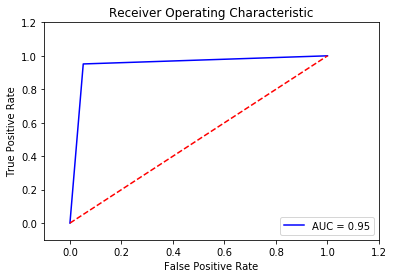

In [85]:
# Токенизация без учёта знаков + стоп-слова
#pipeline, label_pred = train_model_show_results(steps=[('bow', CountVectorizer(analyzer=tokenize)),('classifier', MultinomialNB())])

# Вызывает интернетские функции
#draw_roc_curve(label_pred)


#ошибка, нужно перевести спам и хам в бинарный вид: спам - 1, хам - 0.
# попробуем ещё раз
pipeline, label_pred = train_model_show_results(steps=[('bow', CountVectorizer(analyzer=tokenize)),('classifier', MultinomialNB())])
draw_roc_curve(label_pred)


0.95476109452 0.0131904900754
[1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 1 1 1 1
 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0
 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 1
 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0
 0 0 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0
 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 1 1 0
 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 0 1
 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0
 1 1 0]
             precision    recall  f1-score   support

          0       0.95      0.95      0.95       155
          1       0.94      0.95      0.95       144

avg / total       0.95      0.95      0.95       299

Draw roc curve


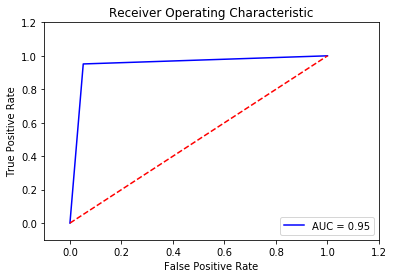

In [87]:
# Тоже самое, но ещё для стоп-слов

pipeline, label_pred = train_model_show_results(steps=[('bow', CountVectorizer(analyzer=tokenize, stop_words=stopwords)),('classifier', MultinomialNB())])
draw_roc_curve(label_pred)

Что-то опять результаты не отличаются... Но если в общем оценивать этот график, то roc-curve идёт практически параллельно ОХ, классификатор справляется отлично, показывая высокие результаты.

Вывод в целом: в нашей сортированной дате (по одинаковому кол-ву сообщений) точность определение спама очень высокая (от 90%) по всем моделям.